In [4]:
import pandas as pd

# Log form:
"""
│2024-02-27T13:28:43.965760 [MAC    ] [D] [   34] SCHED: CQI=15, l=0, nof_bits=39, coderate=3.06, max_coderate=5.55  
"""
logs = {
    "enb0": "data/logs/20240227_1346_enb_0.log",
    "enb1": "data/logs/20240227_1346_enb_1.log",
    "enb2": "data/logs/20240227_1346_enb_2.log",
    "enb3": "data/logs/20240227_1346_enb_3.log",
}

In [34]:
import pandas as pd

logfile1 = "data/logs/20240227_1346_enb_3.log"

def extract_log_data(logfile):
    with open(logfile, "r") as f:
        log_data = f.readlines()
    log_data = [x.strip() for x in log_data]
    log_data = [
        [x[:26], x[28:35].strip(), x[38:39], x[41:]] for x in log_data if x != ""
    ]
    log_data = pd.DataFrame(
        log_data, columns=["timestamp", "thread", "level", "message"]
    )
    return log_data

def get_measurement_data(logfile):
    log_data = extract_log_data(logfile)
    log_data = log_data[
        log_data["message"].str.contains("SCHED: CQI=", na=False)
    ]
    log_data[["cqi", "l", "nof_bits", "coderate", "max_coderate"]] = (
        log_data.message.str.extract(
            r"SCHED: CQI=(.*), l=(.*), nof_bits=(.*), coderate=(.*), max_coderate=(.*)"
        )
    )
    log_data = log_data[["timestamp", "cqi", "l", "nof_bits", "coderate", "max_coderate"]]
    log_data["timestamp"] = pd.to_datetime(log_data["timestamp"])
    log_data["cqi"] = pd.to_numeric(log_data["cqi"])
    log_data["l"] = pd.to_numeric(log_data["l"])
    log_data["nof_bits"] = pd.to_numeric(log_data["nof_bits"])
    log_data["coderate"] = pd.to_numeric(log_data["coderate"])
    log_data["max_coderate"] = pd.to_numeric(log_data["max_coderate"])
    return log_data

def get_rrc_data(logfile):
    # Really should have enabled rrc logging
    log_data = extract_log_data(logfile)
    log_data = log_data[
        log_data["message"].str.contains("SCHED: Added user")
    ]
    log_data["user_id"] = (
        log_data.message.str.extract(
            r"SCHED: Added user rnti=(.*)"
        )
    )
    log_data = log_data[["timestamp", "user_id"]]
    log_data["timestamp"] = pd.to_datetime(log_data["timestamp"])
    return log_data

# log_data = extract_log_data(logfile1)
log_data = get_rrc_data(logfile1)
log_data

,timestamp,user_id
10838,2024-02-27 13:47:43.381222,0x46
10918,2024-02-27 13:47:43.707544,0x47
10943,2024-02-27 13:47:43.727520,0x48
10950,2024-02-27 13:47:43.727637,0x49
10995,2024-02-27 13:47:43.747482,0x4a
...,...,...
418531,2024-02-27 14:01:51.288629,0x8e2
418733,2024-02-27 14:01:51.858523,0x8e3
418799,2024-02-27 14:01:51.998641,0x8e4
427125,2024-02-27 14:02:13.578456,0x8e5


In [28]:
df = pd.DataFrame()
for key, value in logs.items():
    log_data = get_measurement_data(value)
    log_data.to_csv(f"data/processed/{key}.csv", index=False)
    log_data["enb"] = key
    df = pd.concat([df, log_data])

df

,timestamp,cqi,l,nof_bits,coderate,max_coderate,enb
10474,2024-02-27 13:47:39.702978,5,3,28,0.31,0.88,enb0
10483,2024-02-27 13:47:39.711026,5,3,28,0.31,0.88,enb0
10496,2024-02-27 13:47:39.716108,5,2,39,0.76,1.91,enb0
10519,2024-02-27 13:47:39.719056,5,1,28,1.22,1.91,enb0
10580,2024-02-27 13:47:39.869979,13,0,28,2.44,6.23,enb0
...,...,...,...,...,...,...,...
475831,2024-02-27 14:02:38.750465,3,3,28,0.31,0.38,enb3
475840,2024-02-27 14:02:38.758434,3,3,28,0.31,0.38,enb3
475845,2024-02-27 14:02:38.766509,3,3,28,0.31,0.38,enb3
475853,2024-02-27 14:02:38.774447,3,3,28,0.31,0.38,enb3


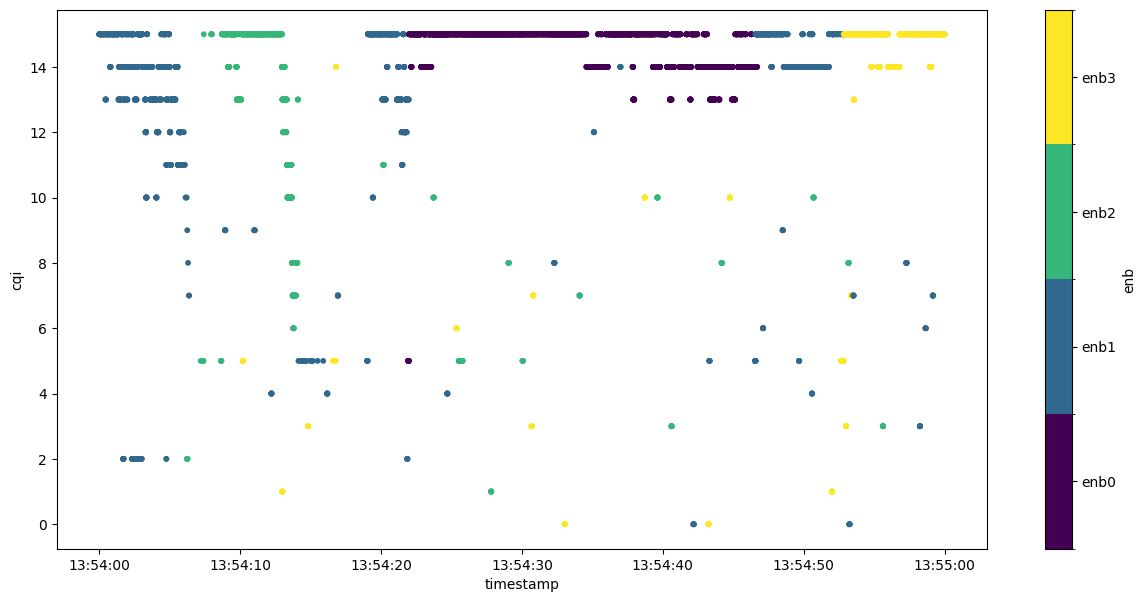

In [27]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 7))
df["enb"] = pd.Categorical(df["enb"])

# Sort the dataframe by timestamp
df = df.sort_values("timestamp")

# Crop to time range between 13:54 and 13:55
df = df[(df["timestamp"] >= "2024-02-27 13:54:00") & (df["timestamp"] <= "2024-02-27 13:55:00")]

# Calculate the time difference between consecutive points
df["time_diff"] = df["timestamp"].diff()

# Create a mask to identify points with time difference less than or equal to 5 seconds
mask = df["time_diff"] <= pd.Timedelta(seconds=1)

# Plot line for each enb type, interpolating only when points are within 5 seconds
# for key, grp in df.groupby("enb"):
    # ax = grp.plot(ax=ax, kind="line", x="timestamp", y="cqi", label=key, drawstyle="steps-post", markevery=mask)
df.plot(ax=ax, kind="scatter", x="timestamp", y="cqi", c="enb", colormap="viridis", s=10)
# Remove the time difference column
df = df.drop("time_diff", axis=1)
